In [5]:
from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parents[0]

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)


import matplotlib.pyplot as plt

from src.data.loaders import load_ohlcv
from src.data.validation import validate_ohlcv
from src.features import add_close_returns, add_volatility_features


PROJECT_ROOT: /workspaces/systematic-trading-framework


In [6]:
df = load_ohlcv("SPY", start="2018-01-01", interval="1d")
validate_ohlcv(df)

df = add_close_returns(df, log=True)  # → close_logret
df = add_volatility_features(
    df,
    returns_col="close_logret",
    rolling_windows=(20, 60),
    ewma_spans=(20,),
    annualization_factor=252.0,
)

df[["close", "close_logret", "vol_rolling_20", "vol_ewma_20"]].tail()


Price,close,close_logret,vol_rolling_20,vol_ewma_20
Date,,,,
2026-01-21,685.400024,0.011475,0.107342,0.132271
2026-01-22,688.979980,0.005210,0.106674,0.128534
2026-01-23,689.229980,0.000363,0.105486,0.122262
2026-01-26,692.729980,0.005065,0.106295,0.118555
2026-01-27,695.489990,0.003976,0.107139,0.113849


### Log-Returns

Οι λογαριθμικές αποδόσεις ορίζονται ως:

$$
r_t = \log\left(\frac{P_t}{P_{t-1}}\right)
$$

όπου:
- \( P_t \): τιμή στο χρόνο \( t \)
- \( r_t \): log-return στο χρόνο \( t \)


### Rolling (Realized) Volatility

Η rolling volatility σε παράθυρο \( n \) παρατηρήσεων ορίζεται ως:

$$
\sigma_t =
\sqrt{
\frac{1}{n - 1}
\sum_{i=0}^{n-1}
\left(r_{t-i} - \bar r_t\right)^2
}
$$

όπου:
- \( r_{t-i} \): log-return στο χρόνο \( t-i \)
- \( \bar r_t \): μέσος όρος των returns στο rolling window
- \( n \): μέγεθος παραθύρου (π.χ. 20 ημέρες)


Η annualized rolling volatility δίνεται από:

$$
\sigma_t^{(\text{ann})} = \sigma_t \sqrt{252}
$$


### EWMA Volatility

Η EWMA (Exponentially Weighted Moving Average) volatility ορίζεται μέσω:

$$
\sigma_t^2 =
(1 - \lambda)
\sum_{k=0}^{\infty}
\lambda^k r_{t-k}^2
$$

με:

$$
\lambda = \frac{2}{\text{span} + 1}
$$

όπου:
- \( \lambda \): παράμετρος αποσβέσης
- μεγαλύτερο βάρος δίνεται στα πιο πρόσφατα returns


$$
\sigma_t^{(\text{ann})} = \sigma_t \sqrt{252}
$$


### Σχόλιο

- Η rolling volatility αντιδρά απότομα σε αλλαγές καθεστώτος,
  αλλά έχει "κοφτές" μεταβάσεις λόγω fixed window.
- Η EWMA volatility είναι πιο ομαλή και πιο responsive σε πρόσφατα shocks,
  αποτυπώνοντας το φαινόμενο του volatility clustering.


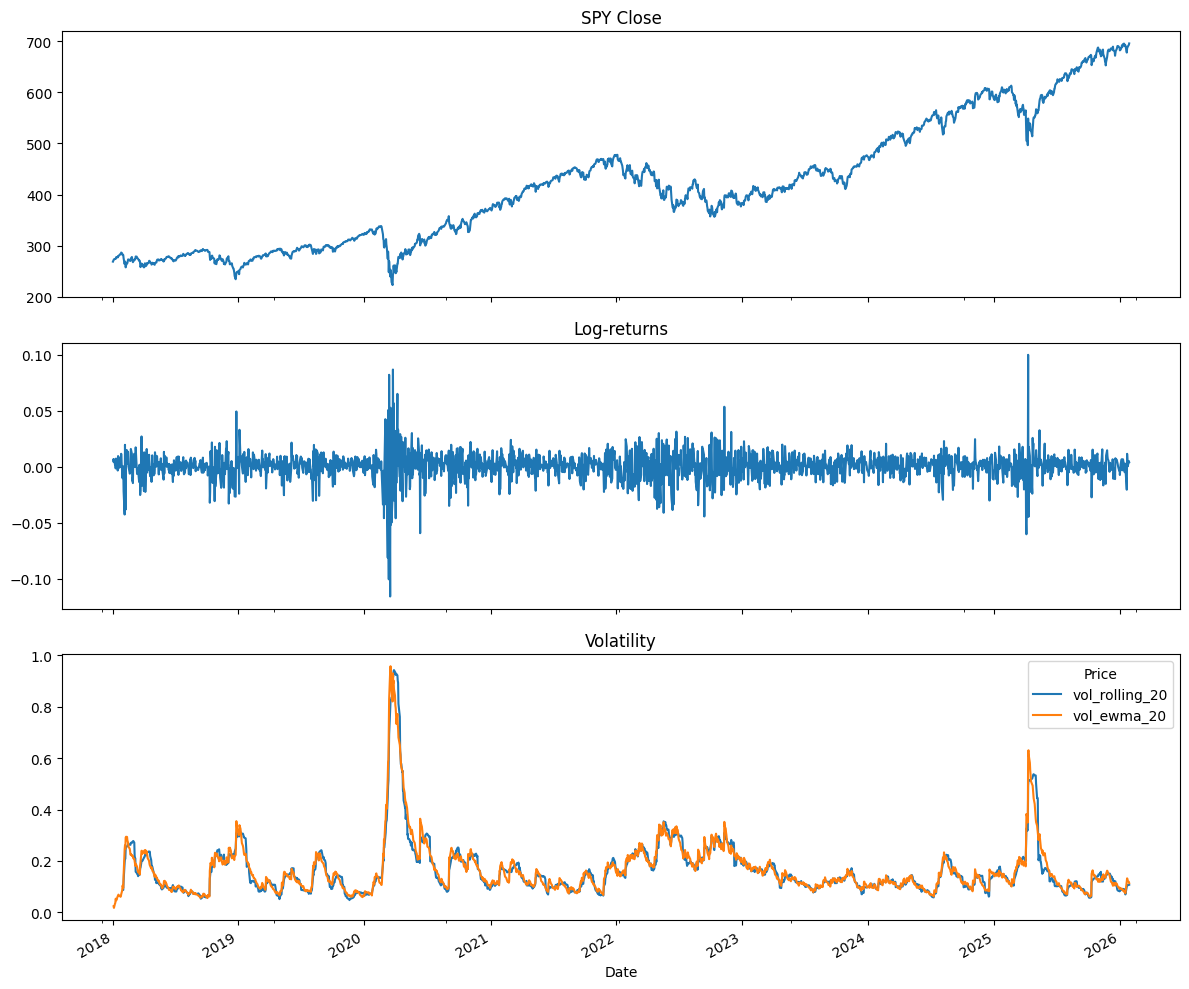

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

df["close"].plot(ax=axes[0]); axes[0].set_title("SPY Close")
df["close_logret"].plot(ax=axes[1]); axes[1].set_title("Log-returns")
df[["vol_rolling_20", "vol_ewma_20"]].plot(ax=axes[2]); axes[2].set_title("Volatility")

plt.tight_layout()
